In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Display settings
pd.set_option('display.max_columns', None)

# Plot style
sns.set(style="whitegrid")


In [8]:
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

print(fraud_df.shape)
fraud_df.head()


(151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [9]:
fraud_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [10]:
fraud_df.isna().sum()


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [11]:
fraud_df = fraud_df.drop_duplicates()


In [12]:
fraud_df['class'].value_counts(normalize=True) * 100


class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

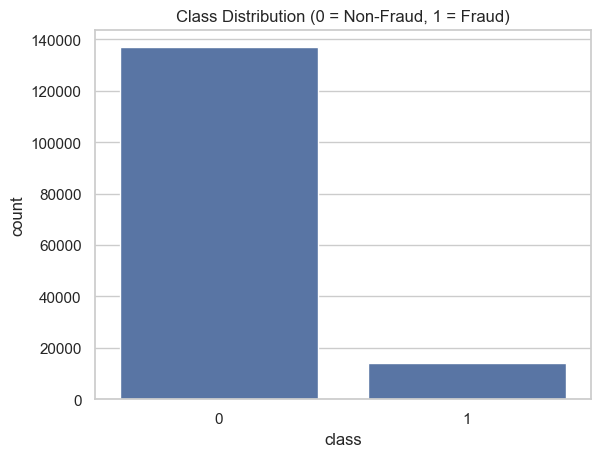

In [13]:
sns.countplot(x='class', data=fraud_df)
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()


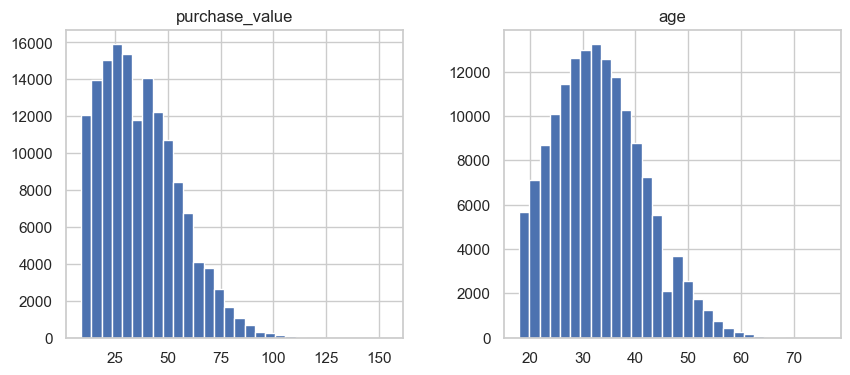

In [14]:
numerical_cols = ['purchase_value', 'age']

fraud_df[numerical_cols].hist(bins=30, figsize=(10,4))
plt.show()


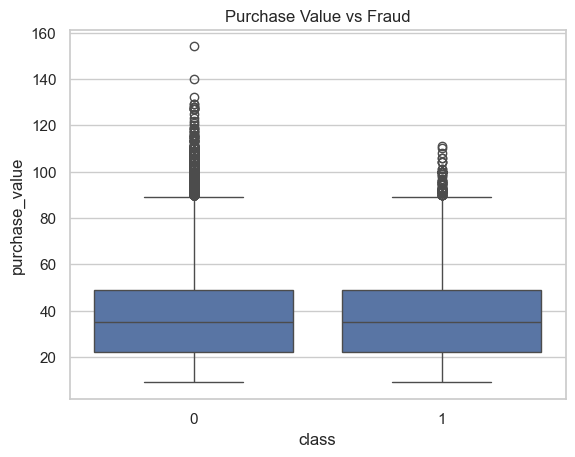

In [15]:
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title("Purchase Value vs Fraud")
plt.show()


In [16]:
fraud_df['ip_address'] = fraud_df['ip_address'].astype(np.int64)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(np.int64)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(np.int64)


In [17]:
ip_df = ip_df.sort_values('lower_bound_ip_address')


In [18]:
fraud_df = pd.merge_asof(
    fraud_df.sort_values('ip_address'),
    ip_df,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)


In [19]:
country_fraud = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)
country_fraud.head(10)


country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

In [20]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])


In [21]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds() / 3600


In [22]:
fraud_df['transaction_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')


In [23]:
categorical_cols = ['source', 'browser', 'sex', 'country']

fraud_df = pd.get_dummies(fraud_df, columns=categorical_cols, drop_first=True)


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scale_cols = ['purchase_value', 'age', 'time_since_signup', 'transaction_count']
fraud_df[scale_cols] = scaler.fit_transform(fraud_df[scale_cols])


In [26]:
fraud_df['class'].value_counts()


class
0    136961
1     14151
Name: count, dtype: int64